# Readability score prediction

## 1. Prepare dataset

First step is to log in the google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive/Xixi')
!ls

Mounted at /content/drive/
1.png			       forest.csv   per.csv		   setup.py
2.png			       LICENSE.txt  readability		   temp.csv
bin			       MANIFEST.in  README.rst		   test.csv
commonlitreadabilityprize.zip  package.zip  sample_submission.csv  train.csv


In [ ]:
# If not unzipped, unzip first
!unzip commonlitreadabilityprize.zip
!unzip package.zip
!pip install readability
!ls

Archive:  commonlitreadabilityprize.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  package.zip
replace .gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: readability in /usr/local/lib/python3.7/dist-packages (0.3.1)


In [2]:
import pandas as pd
import numpy as np
import os
import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import pos_tag, pos_tag_sents
import string
import readability
import spacy

from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

Prepare the dataset

In [3]:
train_df = pd.read_csv("train.csv")
train_df.columns = ['id','url_legal','license','excerpt','score','standard_error']
train_df.head(4)


2834


KstestResult(statistic=0.024668991016583375, pvalue=0.06353286434051546)

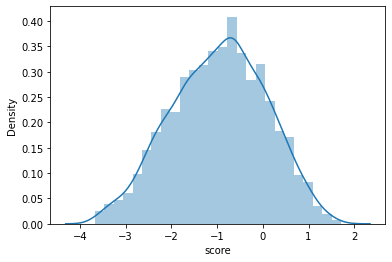

In [4]:
fig1 = sns.distplot(train_df["score"])
scatter_fig1 = fig1.get_figure()
scatter_fig1.savefig('/content/drive/MyDrive/Xixi/1.png',dpi = 400)
u=train_df["score"].mean() #计算均值
std=train_df["score"].std() #计算标准差
stats.kstest(train_df["score"],'norm',(u,std))

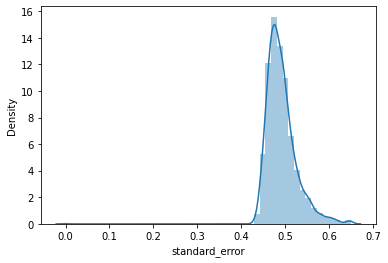

In [5]:
fig2 = sns.distplot(train_df["standard_error"])
scatter_fig2 = fig2.get_figure()
scatter_fig2.savefig('/content/drive/MyDrive/Xixi/2.png',dpi = 400)

In [6]:
test_df = pd.read_csv("test.csv")
test_df.head(2)
print(test_df.iloc[:,0].size)

7


In [7]:
# training set / validation set
# split training set into 2 datasets
# something like data.split(split=0.2)

In [8]:
def readability_measurements(passage: str):
    """
    This function uses the readability library for feature engineering.
    It includes textual statistics, readability scales and metric, and some pos stats
    """
    results = readability.getmeasures(passage, lang='en')
    
    chars_per_word = results['sentence info']['characters_per_word']#每个词的平均长度
    syll_per_word = results['sentence info']['syll_per_word']#每个词的平均音节数
    words_per_sent = results['sentence info']['words_per_sentence']#每局的平均词数
    
    kincaid = results['readability grades']['Kincaid']
    ari = results['readability grades']['ARI']
    coleman_liau = results['readability grades']['Coleman-Liau']
    flesch = results['readability grades']['FleschReadingEase']
    gunning_fog = results['readability grades']['GunningFogIndex']
    lix = results['readability grades']['LIX']
    smog = results['readability grades']['SMOGIndex']
    rix = results['readability grades']['RIX']
    dale_chall = results['readability grades']['DaleChallIndex']
    
    tobeverb = results['word usage']['tobeverb']
    auxverb = results['word usage']['auxverb']
    conjunction = results['word usage']['conjunction']
    pronoun = results['word usage']['pronoun']
    preposition = results['word usage']['preposition']
    nominalization = results['word usage']['nominalization']
    
    pronoun_b = results['sentence beginnings']['pronoun']
    interrogative = results['sentence beginnings']['interrogative']
    article = results['sentence beginnings']['article']
    subordination = results['sentence beginnings']['subordination']
    conjunction_b = results['sentence beginnings']['conjunction']
    preposition_b = results['sentence beginnings']['preposition']

    
    return [chars_per_word, syll_per_word, words_per_sent,
            kincaid, ari, coleman_liau, flesch, gunning_fog, lix, smog, rix, dale_chall,
            tobeverb, auxverb, conjunction, pronoun, preposition, nominalization,
            pronoun_b, interrogative, article, subordination, conjunction_b, preposition_b]

In [9]:
# def spacy_features(df: pd.DataFrame):
#     """
#     This function generates features using spacy en_core_wb_lg
#     I learned about this from these resources:
#     https://www.kaggle.com/konradb/linear-baseline-with-cv
#     https://www.kaggle.com/anaverageengineer/comlrp-baseline-for-complete-beginners
#     """
    
#     nlp = spacy.load('en_core_web_lg')
#     with nlp.disable_pipes():
#         vectors = np.array([nlp(text).vector for text in df.excerpt])
        
#     return vectors

# def get_spacy_col_names():
#     names = list()
#     for i in range(300):
#         names.append(f"spacy_{i}")
        
#     return names

In [10]:
def pos_tag_features(passage: str):
    """
    This function counts the number of times different parts of speech occur in an excerpt
    """
    pos_tags = ["CC", "CD", "DT", "EX", "FW", "IN", "JJ", "JJR", "JJS", "LS", "MD", 
                "NN", "NNS", "NNP", "NNPS", "PDT", "POS", "PRP", "RB", "RBR", "RBS", "RP", "TO", "UH",
                "VB", "VBD", "VBG", "VBZ", "WDT", "WP", "WRB"]
    
    tags = pos_tag(word_tokenize(passage))
    tag_list= list()
    
    for tag in pos_tags:
        tag_list.append(len([i[0] for i in tags if i[1] == tag]))
    
    return tag_list

In [11]:
def generate_other_features(passage: str):
    """
    This function is where I test miscellaneous features
    This is experimental
    """
    # punctuation count
    # periods = passage.count(".")
    # commas = passage.count(",")
    # semis = passage.count(";")
    # exclaims = passage.count("!")
    # questions = passage.count("?")
    
    # Some other stats
    num_char = len(passage)
    num_words = len(passage.split(" "))
    unique_words = len(set(passage.split(" ") ))
    word_diversity = unique_words/num_words
    
    word_len = [len(w) for w in passage.split(" ")]
    longest_word = np.max(word_len)
    avg_len_word = np.mean(word_len)
    
    return [num_char, num_words, unique_words, word_diversity,
            longest_word, avg_len_word]

In [12]:
def create_folds(data: pd.DataFrame, num_splits: int):
    """ 
    This function creates a kfold cross validation system based on this reference: 
    https://www.kaggle.com/abhishek/step-1-create-folds
    """
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin scores
    data.loc[:, "bins"] = pd.cut(
        data["score"], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    
    # fill the new kfold column
    # note that, instead of scores, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data

    # 交叉验证 训练集和测试集不断更替

In [101]:
class CLRDataset:
  # 类定义 调用数据集
    """
    This is my CommonLit Readability Dataset.
    By calling the get_df method on an object of this class,
    you will have a fully feature engineered dataframe
    """
    # 初始化函数
    def __init__(self, df: pd.DataFrame, train: bool, n_folds=2):
        #df.drop(columns=["url_legal","license"])
        self.df = df
        self.excerpts = df["excerpt"]
        
        self._extract_features()
        
        if train:
            self.df = create_folds(self.df, n_folds)
    # 加featuere     
    def _extract_features(self):
        scores_df = pd.DataFrame(self.df["excerpt"].apply(lambda p : readability_measurements(p)).tolist(), 
                                 columns=["chars_per_word", "syll_per_word", "words_per_sent",
                                          "kincaid", "ari", "coleman_liau", "flesch", "gunning_fog", "lix", "smog", "rix", "dale_chall",
                                          "tobeverb", "auxverb", "conjunction", "pronoun", "preposition", "nominalization",
                                          "pronoun_b", "interrogative", "article", "subordination", "conjunction_b", "preposition_b"])
        self.df = pd.merge(self.df, scores_df, left_index=True, right_index=True)
        
        # spacy_df = pd.DataFrame(spacy_features(self.df), columns=get_spacy_col_names())
        # self.df = pd.merge(self.df, spacy_df, left_index=True, right_index=True)
        
        pos_df = pd.DataFrame(self.df["excerpt"].apply(lambda p : pos_tag_features(p)).tolist(),
                              columns=["CC", "CD", "DT", "EX", "FW", "IN", "JJ", "JJR", "JJS", "LS", "MD", 
                                       "NN", "NNS", "NNP", "NNPS", "PDT", "POS", "PRP", "RB", "RBR", "RBS", "RP", "TO", "UH",
                                       "VB", "VBD", "VBG", "VBZ", "WDT", "WP", "WRB"])
        self.df = pd.merge(self.df, pos_df, left_index=True, right_index=True)
        
        other_df = pd.DataFrame(self.df["excerpt"].apply(lambda p : generate_other_features(p)).tolist(),
                                columns=["num_char", "num_words", "unique_words", "word_diversity",
                                         "longest_word", "avg_len_word"])
        self.df = pd.merge(self.df, other_df, left_index=True, right_index=True)
        
    def get_df(self):
        return self.df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        pass

In [14]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [117]:
dataset = CLRDataset(train_df, train=True)
df = dataset.get_df()
df.head() # train dataframe
df.to_csv('')

NameError: ignored

In [146]:
print(df.copy().loc[763]

id                                                        7a1d484be
url_legal                         https://www.africanstorybook.org/
license                                                   CC BY 4.0
excerpt           More people came to the bus stop just before 9...
score                                                       1.54167
                                        ...                        
unique_words                                                    102
word_diversity                                             0.653846
longest_word                                                     11
avg_len_word                                                4.16667
kfold                                                             0
Name: 763, Length: 68, dtype: object


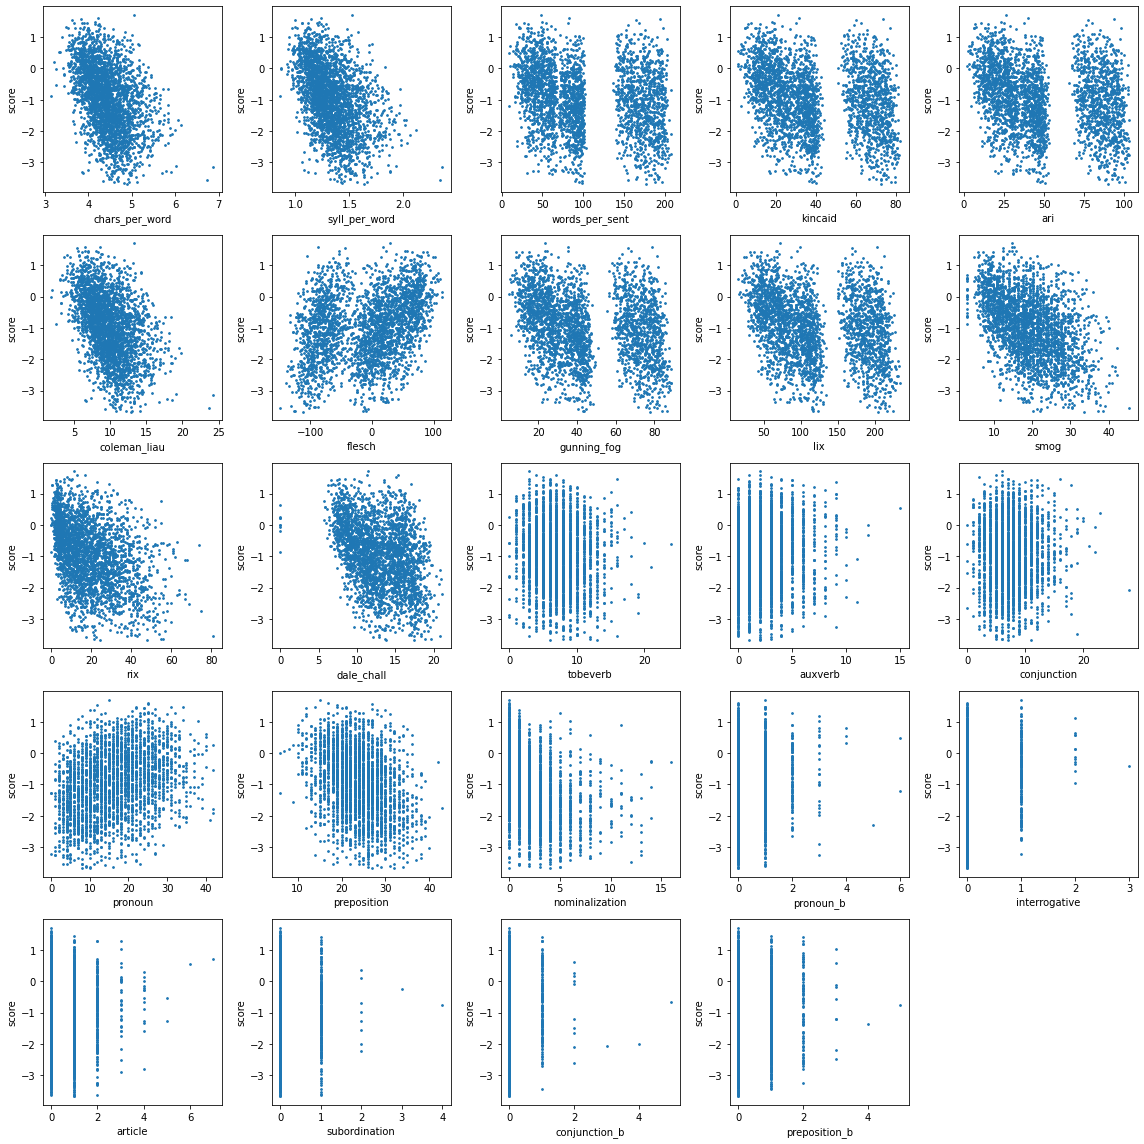

In [16]:
# This is just here to investigate different features
# 不同


plt.figure(figsize=(16,16))
features = ["chars_per_word", "syll_per_word", "words_per_sent",
                                          "kincaid", "ari", "coleman_liau", "flesch", "gunning_fog", "lix", "smog", "rix", "dale_chall",
                                          "tobeverb", "auxverb", "conjunction", "pronoun", "preposition", "nominalization",
                                          "pronoun_b", "interrogative", "article", "subordination", "conjunction_b", "preposition_b"]
i = 1
for feature in features:
  plt.subplot(5,5,i)
  i +=1 
  plt.scatter((df[feature]), df["score"],s=3)
  plt.xlabel(feature)
  plt.ylabel('score')
plt.tight_layout()
plt.show()

In [17]:
test_dataset = CLRDataset(test_df, train=False)
test_df = test_dataset.get_df()
test_df.head() # test dataframe

,id,url_legal,license,excerpt,chars_per_word,syll_per_word,words_per_sent,kincaid,ari,coleman_liau,flesch,gunning_fog,lix,smog,rix,dale_chall,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization,pronoun_b,interrogative,article,subordination,conjunction_b,preposition_b,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNS,NNP,NNPS,PDT,POS,PRP,RB,RBR,RBS,RP,TO,UH,VB,VBD,VBG,VBZ,WDT,WP,WRB,num_char,num_words,unique_words,word_diversity,longest_word,avg_len_word
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...,4.033333,1.186667,50.000000,17.912667,22.567000,7.322849,55.693000,22.133333,66.666667,11.944272,8.333333,8.221833,4,3,4,20,27,1,1,0,0,0,0,0,4,0,20,0,0,22,14,0,0,0,3,31,2,1,0,0,1,11,5,0,0,0,8,0,10,8,3,1,1,0,0,772,147,102,0.693878,11,4.258503
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...,4.086957,1.152174,61.333333,21.925652,28.486232,7.747490,47.107754,26.489855,69.485507,12.486833,5.000000,9.424720,5,6,9,18,21,0,0,0,0,0,0,0,9,0,20,1,0,14,9,0,0,0,6,19,6,17,0,0,2,14,16,2,0,2,7,1,12,18,2,0,2,0,0,967,179,121,0.675978,12,4.407821
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...,4.106742,1.162921,25.428571,8.049615,10.627039,7.182680,82.641854,11.969181,40.035313,8.855400,3.714286,8.357364,8,0,11,27,15,0,2,1,0,0,0,0,11,1,16,2,0,16,10,0,0,0,0,26,3,20,0,0,2,18,8,0,0,1,2,1,1,16,3,2,1,1,2,948,168,122,0.726190,17,4.648810
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...,5.222222,1.783333,45.000000,23.003333,25.666667,14.247589,10.290000,29.111111,80.555556,22.364917,16.000000,12.184500,11,0,4,3,28,2,0,0,0,0,0,0,4,6,19,1,0,25,16,2,0,0,0,46,16,4,0,0,0,0,6,0,0,0,3,0,2,0,2,6,1,0,3,1144,179,106,0.592179,14,5.396648
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...,5.321429,1.738095,84.000000,37.679524,45.633929,15.136174,-25.467857,41.933333,122.095238,25.912878,32.000000,15.697900,8,1,7,7,22,5,0,0,0,0,0,0,7,2,13,0,0,23,9,1,1,0,1,31,16,13,0,0,0,4,5,0,0,0,6,0,5,4,10,4,1,0,1,1094,167,124,0.742515,17,5.556886


## Model

In [18]:
def set_seed(seed=42):
    """ Sets the Seed """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
set_seed(42)

In [19]:
print(df.head())
result2 = np.corrcoef(df.copy().drop(columns=['id',"url_legal","license",'excerpt','score']), rowvar=False)
np.savetxt("temp.csv", result2, delimiter=",")

          id  ... kfold
0  b51730f9c  ...     0
1  4d403fd57  ...     0
2  0f789ee41  ...     0
3  87f96eb79  ...     0
4  b9cca6661  ...     0

[5 rows x 68 columns]


In [20]:
# features = ["chars_per_word", "syll_per_word", "words_per_sent",
#             "kincaid", "ari", "coleman_liau", "flesch", "gunning_fog", "lix", "smog", "rix", "dale_chall",
#             "tobeverb", "auxverb", "conjunction", "pronoun", "preposition", "nominalization", 
#             "pronoun_b", "interrogative", "article", "subordination", "conjunction_b", "preposition_b"]
# # features+=get_spacy_col_names()
# features+=["CC", "CD", "DT", "EX", "FW", "IN", "JJ", "JJR", "JJS", "LS", "MD", 
#             "NN", "NNS", "NNP", "NNPS", "PDT", "POS", "PRP", "RB", "RBR", "RBS", "RP", "TO", "UH",
#             "VB", "VBD", "VBG", "VBZ", "WDT", "WP", "WRB"]
# # currently better results without the other_df features

In [21]:
dataset = CLRDataset(train_df, train=True)
df = dataset.get_df()
df.head() # train dataframe

,id,url_legal,license,excerpt,score,standard_error,chars_per_word,syll_per_word,words_per_sent,kincaid,ari,coleman_liau,flesch,gunning_fog,lix,smog,rix,dale_chall,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization,pronoun_b,interrogative,article,subordination,conjunction_b,preposition_b,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNS,NNP,NNPS,PDT,POS,PRP,RB,RBR,RBS,RP,TO,UH,VB,VBD,VBG,VBZ,WDT,WP,WRB,num_char,num_words,unique_words,word_diversity,longest_word,avg_len_word,kfold
0,b51730f9c,NaN,NaN,"Alice looked at the jury-box, and saw that, in...",-0.432678,0.487498,4.083333,1.220238,28.000000,9.728810,11.802500,7.151899,75.182857,14.533333,39.309524,11.366600,3.166667,7.281014,5,2,7,19,26,0,0,0,0,1,0,0,9,1,18,0,0,18,10,0,0,0,2,22,3,10,0,0,0,12,14,0,0,4,7,0,11,14,5,1,1,2,0,890,163,111,0.680982,17,4.466258,0
1,4d403fd57,https://en.wikipedia.org/wiki/Artificial_intel...,CC BY-SA 3.0,Artificial intelligence (AI) is intelligence e...,-1.161746,0.458396,5.835714,1.971429,70.000000,34.972857,41.056214,18.089651,-30.997857,39.714286,115.714286,27.799194,32.000000,15.341857,6,0,7,6,13,9,0,0,0,0,0,0,7,0,10,0,0,18,20,0,0,0,0,26,16,5,0,0,0,0,6,0,0,0,1,0,3,2,3,7,3,0,1,982,139,106,0.762590,13,6.071942,0
2,0f789ee41,NaN,NaN,A gruff squire on horseback with shiny top boo...,-2.367914,0.519369,3.929936,1.133758,31.400000,10.034344,12.780000,6.364366,79.048076,14.343439,41.591083,9.480741,3.200000,9.015723,0,1,2,18,25,0,2,0,1,0,0,0,2,1,23,0,0,19,10,0,0,0,1,28,6,11,0,0,0,10,5,0,0,4,5,0,9,6,3,2,0,1,0,815,153,107,0.699346,16,4.333333,0
3,87f96eb79,NaN,NaN,But that hadn't helped Washington.\nThe Americ...,-0.842596,0.466193,4.459893,1.294118,62.333333,23.990588,30.742763,9.948040,34.084314,27.500178,76.237077,13.954451,8.666667,10.274650,7,4,7,8,30,3,0,0,1,0,1,1,7,2,25,2,0,24,13,0,2,0,4,19,15,11,0,0,0,7,14,2,0,2,4,0,4,16,5,0,0,1,2,1048,184,130,0.706522,16,4.701087,0
4,b9cca6661,NaN,NaN,The principal business of the people of this c...,-0.748452,0.433000,4.089385,1.201117,59.666667,21.853184,27.664339,7.748297,44.658808,26.995158,72.515829,14.832160,7.666667,8.624849,12,1,10,14,26,1,0,0,2,0,0,1,10,0,31,3,0,24,18,1,0,0,1,28,8,2,0,0,0,7,12,1,0,0,5,0,4,16,0,0,2,0,1,932,177,104,0.587571,11,4.271186,0


## Customized models

In [147]:
df = df.drop(columns=['WP','RP','POS','JJR','preposition_b','article','JJS','EX','PDT','pronoun_b','RBR','NNPS','RBS','conjunction_b','interrogative','subordination','UH','FW'])
df.to_csv('12.csv')

In [115]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation
from keras.models import Sequential
class models():
    def __init__(self, df, n_components=40, IF_PCA=True):
        self.data_process(df)
        if IF_PCA:
            print("PCA components: ",n_components)
            self.PCA(n_components)
        else:
            print("Didn't use PCA, features:", self.x.shape)

        self.X_train, self.X_val, self.y_train, self.y_val = self.train_val()

    def data_process(self, df_copy):
        '''
        the function is to process raw data
        and store the training set and split into validation dataset
        '''
        # Normalization
        scaler = MinMaxScaler()
        y = np.array(df_copy["score"])
        self.y = y
        self.standard_error = df_copy["standard_error"]
        df_copy = df_copy.drop(columns=['id',"url_legal","license",'excerpt','score','kfold','standard_error']) # drop the unused elements
        df_copy = scaler.fit_transform(df_copy)
        x = df_copy
        self.x = x

        scaler = MinMaxScaler(feature_range=(0,100))
        scaler.fit(self.y.reshape(-1,1))
        self.scaler = scaler
        print("After reading dataframe, x :", x.shape)
        print("Y scores: ", y.shape)
    
    def PCA(self, n_components=40):
        pca = PCA(n_components=n_components)
        principalComponents = pca.fit_transform(self.x)
        print("After PCA, features:", principalComponents.shape)
        self.x = np.array(principalComponents) # x: after PCA data
    
    def train_val(self,test_size=0.2):
        print("Spliting the dataset: ")
        X_train, X_val, y_train, y_val = train_test_split(self.x, self.y, test_size=0.2, random_state=1)
        print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
        return X_train, X_val, y_train, y_val

    def define_model(self, name, args):
        '''
        define your models here
        args: list , containing all the argments you need
        '''
        self.name = name
        if name == "Ridge":
            # self.define_model("Ridge",[0.2])
            if not args:
                alpha = 0.1
            else:
                alpha = args[0]
            self.model = Ridge(alpha)
        elif name == "NN":
            # neural network (sequential)
            # Initialising the ANN
            self.epochs = args[0]
            feature = self.x.shape[1]
            model = Sequential()
            # Adding the input layer and the first hidden layer
            model.add(Dense(32, activation = 'relu', input_dim = feature))
            # Adding the second hidden layer
            model.add(Dense(units = 32, activation = 'relu'))
            # Adding the third hidden layer
            model.add(Dense(units = 32, activation = 'relu'))
            # Adding the output layer
            model.add(Dense(units = 1))
            model.summary()
            self.model = model
        

    def train(self):
        model = self.model
        if self.name == "Ridge":
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_val)
            error = mean_squared_error(self.y_val, y_pred)
            print("Ridge model, evaluated by MSE: ", error)
        elif self.name == "NN":
            model.compile(optimizer = 'adam',loss = 'mean_squared_error')
            model.fit(self.X_train, self.y_train, batch_size = 10, epochs = 100, verbose=1)

    def predict(self, X):
        # return scores of each x
        model = self.model
        if self.name == "Ridge":
            y_pred =  model.predict(X)
            y_pred = self.transform(y_pred)
            return y_pred
        elif self.name == "NN":
            y_pred = model.predict(X)
            y_pred = self.transform(y_pred)
            return y_pred

    def evaluate(self):
        if self.name == "Ridge":
            self.plot_result(self.predict(self.X_train), self.y_train, np.argsort(self.y_train), self.standard_error)
        elif self.name == "NN":
            self.plot_result(self.predict(self.X_train), self.y_train, np.argsort(self.y_train), self.standard_error)
            

    def plot_result(self, y_pred, y_train, indexs, standard_error):
        plt.figure(figsize=(10,8))
        plt.title(self.name + " model prediction performance",)
        plt.ylabel("scores")
        y_pred = [y_pred[indexs[i]] for i in range(len(indexs))]
        y_train = [y_train[indexs[i]] for i in range(len(indexs))]
        standard_error = [standard_error[indexs[i]] for i in range(len(indexs))]
        first = self.transform(np.array([y_train[i]-standard_error[i] for i in range(len(y_train))]).reshape(-1,1))
        second = self.transform(np.array([y_train[i]+standard_error[i] for i in range(len(y_train))]).reshape(-1,1))
        y_train = self.transform(np.array(y_train).reshape(-1,1))
        plt.plot(y_pred,label="y_pred")
        plt.plot(y_train,label="y_train")
        plt.plot(first,label="standard_error")
        plt.plot(second,label="standard_error")
        plt.legend()
        plt.savefig('00.png',dpi=500)
        plt.show()

    def transform(self, scores):
        '''
        transform orginal output y_pred to range 0-100 
        '''
        scores = self.scaler.transform(scores.reshape(-1,1))
        return scores

In [77]:
df_copy = df.copy()
# df_copy['score']

In [79]:
model = models(df_copy,n_components=43)

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
PCA components:  43
After PCA, features: (2834, 43)
Spliting the dataset: 
(2267, 43) (567, 43) (2267,) (567,)


In [80]:
model.define_model("Ridge",[0.2])

In [81]:
model.train()

Ridge model, evaluated by MSE:  0.6421928602468191


In [66]:
# pred = model.predict(X_train)
# print(pred)

NameError: ignored

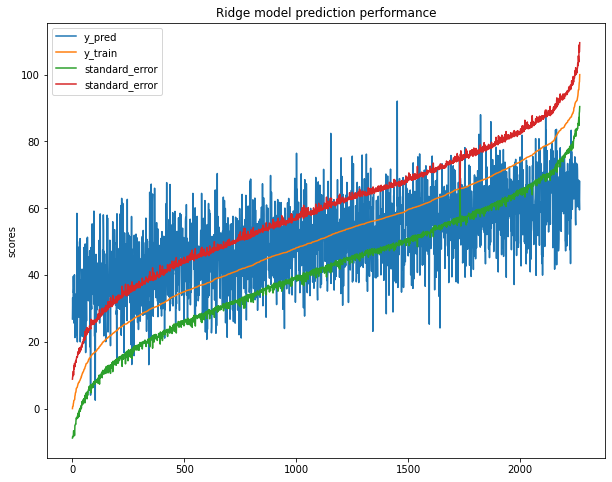

In [71]:
model.evaluate()

Not using PCA

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
Didn't use PCA, features: (2834, 43)
Spliting the dataset: 
(2267, 43) (567, 43) (2267,) (567,)
Ridge model, evaluated by MSE:  0.6421928602468179


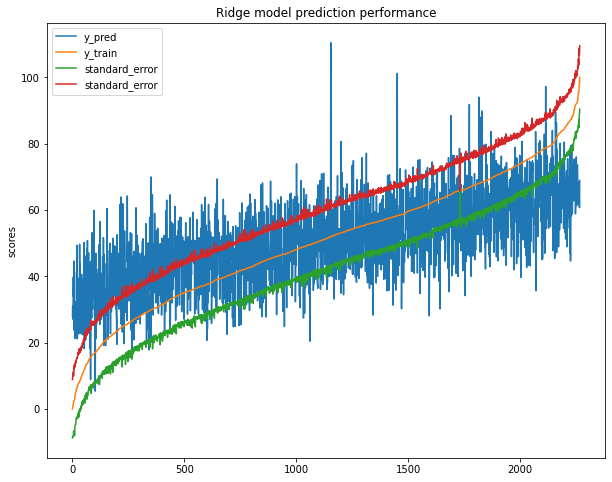

In [106]:
model = models(df_copy,IF_PCA=False)
model.define_model("Ridge",[0.2])
model.train()
model.evaluate()

Compare 5 models

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
PCA components:  6
After PCA, features: (2834, 6)
Spliting the dataset: 
(2267, 6) (567, 6) (2267,) (567,)
Ridge model, evaluated by MSE:  0.7761961934851783


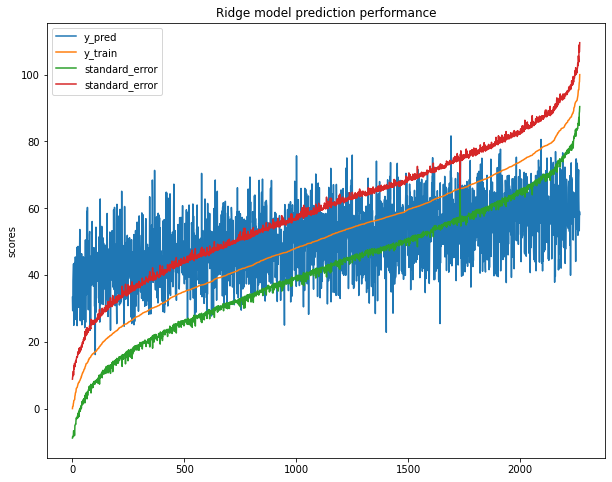

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
PCA components:  13
After PCA, features: (2834, 13)
Spliting the dataset: 
(2267, 13) (567, 13) (2267,) (567,)
Ridge model, evaluated by MSE:  0.692397789379157


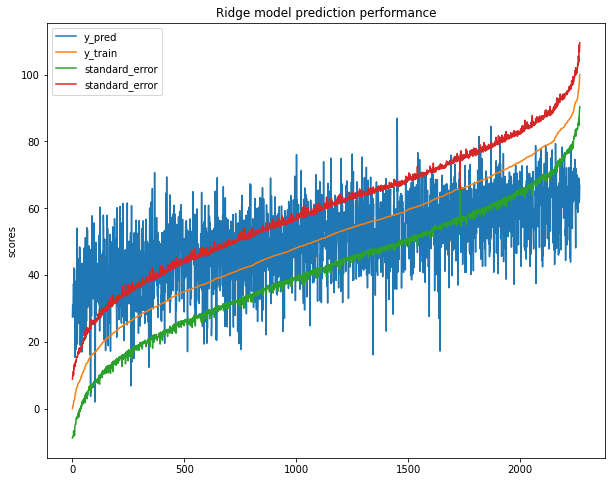

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
PCA components:  20
After PCA, features: (2834, 20)
Spliting the dataset: 
(2267, 20) (567, 20) (2267,) (567,)
Ridge model, evaluated by MSE:  0.6820877846589799


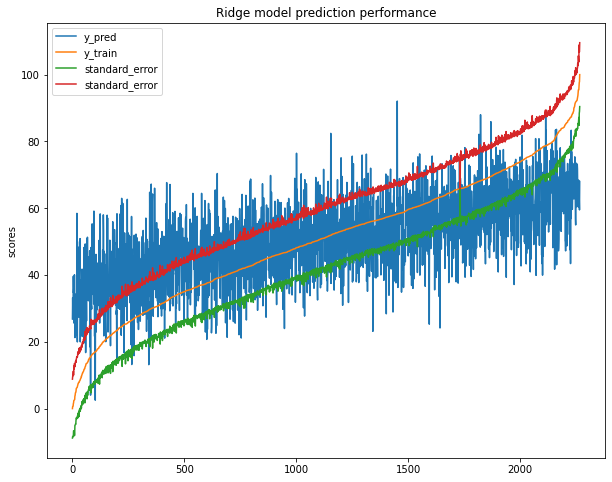

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
PCA components:  27
After PCA, features: (2834, 27)
Spliting the dataset: 
(2267, 27) (567, 27) (2267,) (567,)
Ridge model, evaluated by MSE:  0.6650935277230624


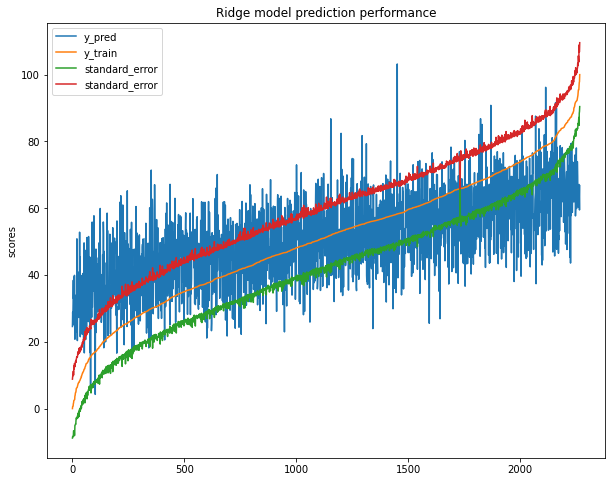

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
PCA components:  34
After PCA, features: (2834, 34)
Spliting the dataset: 
(2267, 34) (567, 34) (2267,) (567,)
Ridge model, evaluated by MSE:  0.6490204855923729


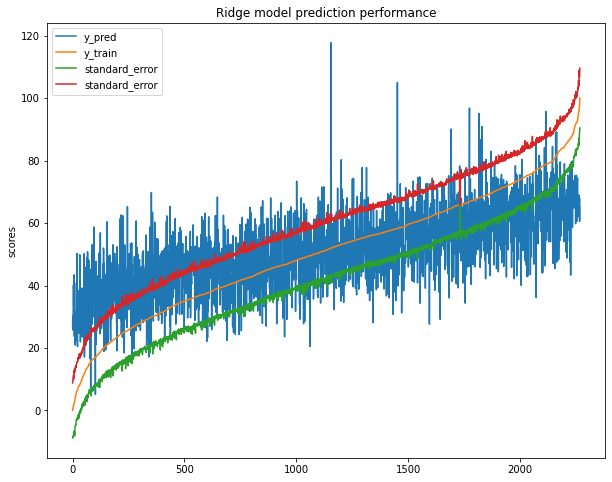

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
PCA components:  41
After PCA, features: (2834, 41)
Spliting the dataset: 
(2267, 41) (567, 41) (2267,) (567,)
Ridge model, evaluated by MSE:  0.6421928602468191


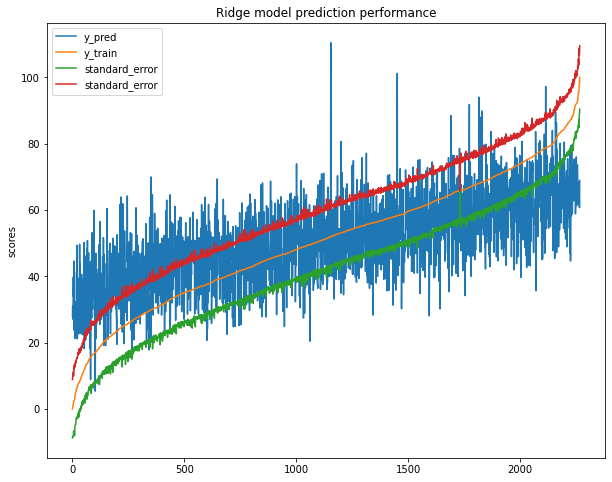

In [82]:
for i in range(6,44,7):
    components = i
    model = models(df_copy,n_components=components)
    model.define_model("Ridge",[0.2])
    model.train()
    model.evaluate()

NN

In [148]:
model = models(df_copy,n_components=43)
model.define_model("NN",[100])
model.train()

After reading dataframe, x : (2834, 43)
Y scores:  (2834,)
PCA components:  43
After PCA, features: (2834, 43)
Spliting the dataset: 
(2267, 43) (567, 43) (2267,) (567,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                1408      
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,553
Trainable params: 3,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
22

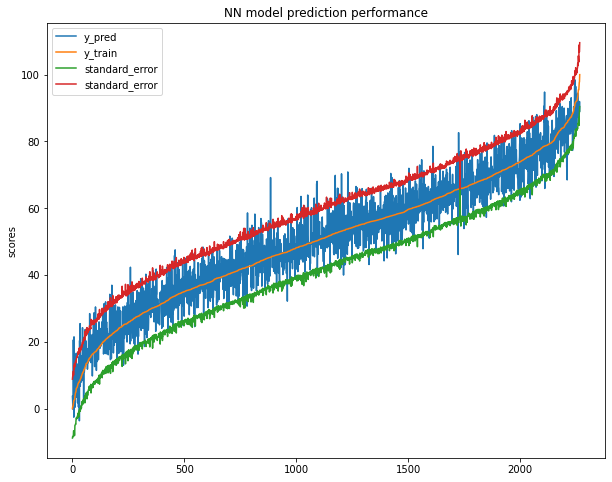

In [112]:
model.evaluate()

In [150]:
model.transform([1.711389827])

AttributeError: ignored

In [113]:
dev_df = pd.read_csv("article.csv")
dev_df.columns = ['excerpt']
dev_df.head(2)
dev_data = CLRDataset(dev_df, train=False)
dev = dev_data.get_df().drop(columns=['excerpt','WP','RP','POS','JJR','preposition_b','article','JJS','EX','PDT','pronoun_b','RBR','NNPS','RBS','conjunction_b','interrogative','subordination','UH','FW'])
dev.head()

,chars_per_word,syll_per_word,words_per_sent,kincaid,ari,coleman_liau,flesch,gunning_fog,lix,smog,rix,dale_chall,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization,CC,CD,DT,IN,JJ,LS,MD,NN,NNS,NNP,PRP,RB,TO,VB,VBD,VBG,VBZ,WDT,WRB,num_char,num_words,unique_words,word_diversity,longest_word,avg_len_word
0,4.237624,1.316832,25.250000,9.796114,11.154208,7.944019,69.802290,12.080198,43.071782,9.123724,4.500,7.859296,4,0,7,18,15,0,7,0,1,8,12,0,0,19,4,3,13,9,0,1,0,5,4,0,0,553,97,50,0.515464,13,4.711340
1,3.578431,1.019608,25.500000,6.386373,8.174412,4.079554,94.693676,10.592157,38.245098,5.738613,3.250,8.616594,3,2,3,17,13,0,3,2,7,7,8,0,2,14,8,6,15,5,3,3,1,1,2,0,0,487,96,73,0.760417,10,4.083333
2,4.141256,1.260090,74.333333,28.269058,35.241981,8.151127,24.783079,32.513602,88.458894,15.449900,10.500,11.147021,7,5,15,29,58,2,15,8,57,53,35,0,4,94,32,13,21,14,15,21,18,9,6,1,5,2383,447,265,0.592841,14,4.333333
3,4.750716,1.455587,43.625000,18.599681,22.758374,11.454482,39.412932,22.492980,63.395774,15.845233,8.625,11.998667,9,5,13,24,45,3,14,2,36,48,25,0,5,51,42,11,8,16,9,15,12,10,9,1,7,2047,337,201,0.596439,19,5.077151


In [116]:
pred = model.predict(dev)
print(pred)

[[22942.63 ]
 [19489.021]
 [97841.13 ]
 [82014.99 ]]
